### Importing the Libraries

In [7]:
import math
import glob

import h5py

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import losses
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import rc, cm
from matplotlib.pyplot import subplots
from matplotlib.animation import FuncAnimation
from IPython import display
plt.rcParams['animation.ffmpeg_path'] = '/home/mi/chanakya/.conda/envs/py_36/bin/ffmpeg'
import pandas as pd
import seaborn
print("Version:", tf.__version__)

Version: 2.2.0


### Prepocessing Functions for Accuracy and Model Import

In [8]:
def transform_coordinates(state):
  # state has x , y, dx ,dy 
    state_ = np.zeros_like(state)
    state_[:, :, 0] = state[:, :, 0] - 50
    state_[:, :, 1] = - state[:, :, 1] + 50
    state_[:, :, 2] = state[:, :, 2]
    state_[:, :, 3] = - state[:, :, 3]
    return state_

In [9]:
def return_view_of_the_agents(socf, soof, max_dist, no_of_bins, total_angle):
    # socf: state of fish under considerdation
    # soof: states of other fish (can be a batch)
    # total angle is in radian (angle whos bins are to be taken)
    # The logic for this method is that we look at at how close the other fish are to the the angle biscetors using a dot product. 
    orientation_socf = np.arctan2(socf[3], socf[2])
    angle_bisectors = np.array(range(int(math.floor(no_of_bins/2)), -int(math.floor(no_of_bins/2)) -1 , -1)) * total_angle / no_of_bins + orientation_socf
    shape = np.shape(soof)
    socf_vector_cos = np.cos(angle_bisectors)
    socf_vector_sin = np.sin(angle_bisectors)
    view_of_the_agents = np.zeros(no_of_bins)
    for i in range(shape[0]):
        soof_X = soof[i, 0] - socf[0]
        soof_Y = soof[i,1] - socf[1]
        soof_vector_cos = np.cos(np.arctan2(soof_Y, soof_X))
        soof_vector_sin = np.sin(np.arctan2(soof_Y, soof_X))
        angle = np.arccos(np.clip(soof_vector_cos * socf_vector_cos[int(math.floor(no_of_bins/2))] + soof_vector_sin * socf_vector_sin[int(math.floor(no_of_bins/2))], -1, 1))
        if angle > - total_angle/2 and angle < total_angle/2:
            max_bin = np.argmax(socf_vector_cos * soof_vector_cos + socf_vector_sin * soof_vector_sin)
            distance = np.sqrt(soof_X ** 2 + soof_Y ** 2)
            if view_of_the_agents[max_bin] < 1 - distance / max_dist :
                view_of_the_agents[max_bin] =  1 - distance / max_dist
    return view_of_the_agents

In [10]:
def return_view_of_the_walls(socf, wall_boundaries, max_dist, no_of_bins, total_angle):
  # wall_boundaries contain +x, -x, +y and -y of the walls (Basically equations of the lines that describe the walls)
    orientation_socf = np.arctan2(socf[3], socf[2])
    angles = np.array(range(int(math.floor(no_of_bins/2)), -int(math.floor(no_of_bins/2)) -1 , -1)) * total_angle / no_of_bins + orientation_socf
    slopes = np.tan(angles)
    socf_cos = np.cos(angles)
    socf_sin = np.sin(angles)
#     print(slopes)
#     print(angles)
    view_of_walls = np.zeros(no_of_bins)
    for i in range(len(slopes)):
        for j in range(len(wall_boundaries)):
            if (j < 2):
                if (slopes[i] > np.tan(0.99 * np.pi/2)) or (slopes[i] < np.tan(-0.99 * np.pi/2)) :
                # Condition to not evaluate the lines paralell to lines +x and - x
                    continue
                else: 
                    y = slopes[i] * (wall_boundaries[j]*1.0 - socf[0]) + socf[1]
                    angle = np.arctan2((y - socf[1]), (wall_boundaries[j]*1.0 - socf[0]))
                    vector_cos = np.cos(angle)
                    vector_sin = np.sin(angle)
                    index = np.argmax(vector_cos * socf_cos + vector_sin * socf_sin)
#                     print(i, index, wall_boundaries[j], y)
                    if (y < wall_boundaries[2]) and (y > wall_boundaries[3]) and (index == i):
#                         print('Selected:', y)
                        view_of_walls[i] = 1 - np.sqrt((socf[0] - wall_boundaries[j])**2 + (socf[1] - y)**2) / max_dist
                        break
            if (j>=2 and j < 4):
                if slopes[i] < np.tan(0.001 * np.pi/2) and slopes[i] > np.tan(-0.001 * np.pi/2) :
                    # Condition to not evaluate the lines parallel or almost parallel to + y and - y
                    continue
                else: 
                    x = (wall_boundaries[j] - socf[1]) / slopes[i] + socf[0]
                    angle = np.arctan2((wall_boundaries[j] - socf[1]), (x - socf[0]))
                    vector_cos = np.cos(angle)
                    vector_sin = np.sin(angle)
                    index = np.argmax(vector_cos * socf_cos + vector_sin * socf_sin)
#                     print(i, index, x, wall_boundaries[j])
                    if  (x < wall_boundaries[0]) and (x > wall_boundaries[1]) and (index == i):
#                         print('Selected', x)
                        view_of_walls[i] = 1 - np.sqrt((socf[0] - x)**2 + (socf[1] - wall_boundaries[j])**2) / max_dist
                        break

    return view_of_walls

In [11]:
def return_binned_velocities(current_state, previous_state, max_linear_velo, lin_vel_bins, max_ang_velo, ang_vel_bins):
    vel_lin_bins = np.array(range(0, lin_vel_bins + 1 , 1)) * max_linear_velo / lin_vel_bins - max_linear_velo / 2 
    vel_ang_bins = np.array(range(0, ang_vel_bins + 1 , 1)) * max_ang_velo / ang_vel_bins - max_ang_velo / 2 

    vel_x = current_state[0] - previous_state[0]
    vel_y = current_state[1] - previous_state[1]
    vel_ang = np.arctan2(current_state[3], current_state[2]) - np.arctan2(previous_state[3], previous_state[2])
    vel_x_binned = np.zeros(lin_vel_bins)
    vel_y_binned = np.zeros(lin_vel_bins)
    vel_ang_binned = np.zeros(ang_vel_bins)

    for i in range(lin_vel_bins):
        if vel_x > vel_lin_bins[i] and vel_x < vel_lin_bins[i + 1]:
            vel_x_binned[i] = 1
        if vel_y > vel_lin_bins[i] and vel_y < vel_lin_bins[i + 1]:
            vel_y_binned[i] = 1

        for i in range(ang_vel_bins):
            if vel_ang > vel_ang_bins[i] and vel_ang < vel_ang_bins[i + 1]:
                vel_ang_binned[i] = 1

    return vel_x_binned, vel_y_binned, vel_ang_binned

In [12]:
def return_speeds(current_state, previous_state, max_speed, max_ang_velo):
    speed = np.sqrt((current_state[0] - previous_state[0])**2 + (current_state[1] - previous_state[1])**2)
    speed = min(speed, max_speed)
    angular_velocity = np.arctan2(current_state[3], current_state[2]) - np.arctan2(previous_state[3], previous_state[2])
    if angular_velocity > np.pi:
        angular_velocity = angular_velocity - 2 * np.pi
    if angular_velocity < -np.pi:
        angular_velocity = angular_velocity + 2 * np.pi
    
    angular_velocity = min(angular_velocity, max_ang_velo) * (angular_velocity >= 0) + max(angular_velocity, -max_ang_velo) * (angular_velocity < 0)
    return speed, angular_velocity

In [13]:
def return_binned_speeds(current_state, previous_state, max_speed, no_speed_bins, max_ang_velo, ang_vel_bins):
    speed = np.sqrt((current_state[0] - previous_state[0])**2 + (current_state[1] - previous_state[1])**2)
    speed = min(speed, max_speed)
    speed_bins = np.array(range(-no_speed_bins, no_speed_bins + 1 , 2)) * max_speed / (no_speed_bins - 1) 
    vel_ang_bins = np.array(range(-ang_vel_bins, ang_vel_bins + 1, 2)) * max_ang_velo / (ang_vel_bins - 1) 
    vel_ang = np.arctan2(current_state[3], current_state[2]) - np.arctan2(previous_state[3], previous_state[2])
    
    if vel_ang > np.pi:
        vel_ang = vel_ang - 2 * np.pi
    if vel_ang < -np.pi:
        vel_ang = vel_ang + 2 * np.pi
    
    vel_ang = min(vel_ang, max_ang_velo) * (vel_ang >= 0) + max(vel_ang, -max_ang_velo) * (vel_ang < 0)
    vel_ang_binned = np.zeros(ang_vel_bins)
    speed_binned = np.zeros(no_speed_bins)
    
#     print(speed_bins)
#     print(vel_ang_bins)
    for i in range(no_speed_bins):
        if speed > speed_bins[i] and speed < speed_bins[i + 1]:
            speed_binned[i] = 1
            
    for i in range(ang_vel_bins):
        if vel_ang > vel_ang_bins[i] and vel_ang < vel_ang_bins[i + 1]:
            vel_ang_binned[i] = 1    
    
    return speed_binned, vel_ang_binned

In [14]:
def data_to_model(type_ ,path, random, no_of_trajectories, max_dist, no_of_bins_voa, total_angle_voa, wall_boundaries, no_of_bins_vow, total_angle_vow, max_speed, speed_bins, max_ang_velo, ang_vel_bins, include_y_labels):
    
    if random == 1:
        random_selection = np.random.randint(0,np.shape(path)[0], no_of_trajectories)
    else:
        random_selection = np.array(range(len(path)))
    
    agents = []
    actual_no_of_agents = 0
    
    if include_y_labels == 0:
        for j in random_selection:
            agents.append([])

        for j, p in zip(random_selection, range(len(random_selection))):

            hf = h5py.File(path[j], 'r')
            keys = list(hf.keys())

            for k in range(len(keys)):

                agents[p].append(np.asarray(hf.get(keys[k])))
                actual_no_of_agents += 1

            agents[p] = transform_coordinates(np.asarray(agents[p]))
    else:
        p = 0
        for j in random_selection:
            hf = h5py.File(path[j], 'r')
            keys = list(hf.keys())
            if len(keys) == 2:
                agents.append([])
                
                for k in range(len(keys)):
                    agents[p].append(np.asarray(hf.get(keys[k])))
                agents[p] = transform_coordinates(np.asarray(agents[p]))
                p = p + 1
                    
    
    agents_voa_vow_sp_av = []
    agents_sp_binned = []
    agents_va_binned = []
    agents_y_label = []
    
    for j in range(len(agents)):
        
        shape = np.shape(agents[j])
        agents_voa_vow_sp_av.append(np.zeros((shape[0], shape[1], no_of_bins_voa + no_of_bins_vow + 2)))
        agents_sp_binned.append(np.zeros((shape[0], shape[1]-1 , speed_bins)))
        agents_va_binned.append(np.zeros((shape[0], shape[1]-1, ang_vel_bins)))
        agents_y_label.append(np.zeros((shape[0], shape[1]-1, 1)))
    
    
    for j in range(len(agents)):
            
            shape = np.shape(agents[j])
            
            for k in range(shape[1]):
                
                for l in range(shape[0]):
                    if shape[0] > 0:
                        other_agents = np.append(agents[j][0:l,k,:], agents[j][l+1:, k, :], axis = 0)
                        agents_voa_vow_sp_av[j][l,k,0:no_of_bins_voa] = return_view_of_the_agents(agents[j][l,k,:], other_agents, max_dist, no_of_bins_voa, total_angle_voa)
                        
                        
                    agents_voa_vow_sp_av[j][l,k,no_of_bins_voa : no_of_bins_voa + no_of_bins_vow] = return_view_of_the_walls(agents[j][l,k,:], wall_boundaries, max_dist, no_of_bins_vow, total_angle_vow)
                    
                    if k > 0:
                        speed, ang_vel = return_speeds(agents[j][l, k, :], agents[j][l,k-1,:], max_speed, max_ang_velo)
                        agents_voa_vow_sp_av[j][l,k, no_of_bins_voa + no_of_bins_vow], agents_voa_vow_sp_av[j][l,k, no_of_bins_voa + no_of_bins_vow + 1] = speed, ang_vel
                        agents_sp_binned[j][l,k-1,:], agents_va_binned[j][l,k-1,:] = return_binned_speeds(agents[j][l, k, :], agents[j][l,k-1,:], max_speed, speed_bins, max_ang_velo, ang_vel_bins)
                        
                        if shape[0] == 2:
                            other_agents = np.append(agents[j][0:l,k-1,:], agents[j][l+1:, k-1, :], axis = 0)
                            cos_theta = np.cos(ang_vel + np.arctan2(agents[j][l,k-1,3], agents[j][l,k-1,2]))
                            sin_theta = np.sin(ang_vel + np.arctan2(agents[j][l,k-1,3], agents[j][l,k-1,2]))
                            cos_agent = other_agents[0,0] - agents[j][l,k-1,0]
                            sin_agent = other_agents[0,1] - agents[j][l,k-1,1]
                            agents_y_label[j][l, k-1, :] = speed * (cos_theta * cos_agent + sin_theta * sin_agent)/ (max_speed * max_dist) 
                
    
    
    for j in range(len(agents) - 1):
        agents_voa_vow_sp_av[0] = np.append(agents_voa_vow_sp_av[0],agents_voa_vow_sp_av[j+1], axis = 0)
        agents_sp_binned[0] = np.append(agents_sp_binned[0], agents_sp_binned[j+1], axis = 0)
        agents_va_binned[0] = np.append(agents_va_binned[0], agents_va_binned[j+1], axis = 0)
        agents_y_label[0] = np.append(agents_y_label[0], agents_y_label[j+1], axis = 0)
    
    X = agents_voa_vow_sp_av[0][:,0:np.shape(agents_voa_vow_sp_av[0])[1] - 1]
    Y1 = agents_sp_binned[0]
    Y2 = agents_va_binned[0]
    Y3 = agents_y_label[0]
    
    if type_ == 1:
        X = np.reshape(X, (np.shape(X)[0], np.shape(X)[1], 1, 2, no_of_bins_voa + 1))
    
    return X, Y1, Y2, Y3

In [15]:
def data_to_model_csv_rf(type_ , path_rf, random, no_of_trajectories_rf, time_steps, max_dist, no_of_bins_voa, total_angle_voa, wall_boundaries, no_of_bins_vow, total_angle_vow, max_speed, speed_bins, max_ang_velo, ang_vel_bins):

    agents_rf = []

    if random == 1:
        random_selection_rf = np.random.randint(0, np.shape(path_rf)[0], no_of_trajectories_csv)
    else:
        random_selection_rf = np.array(range(len(path_rf)))

    for j in random_selection_rf:
        agents_rf.append([])

    for j, p in zip(random_selection_rf, range(len(random_selection_rf))):
        rf_data = np.asarray(pd.read_csv(path_rf[j]))
        rf_proc = np.zeros((2, np.shape(rf_data)[0], 4))
        rf_proc[0, :, 0:2] = rf_data[:, 11:13].astype(np.float) 
        rf_proc[0, :, 2], rf_proc[0, :, 3] = rf_data[:, 14].astype(np.float), rf_data[:, 14].astype(np.float) 
        rf_proc[1, :, 0:2] = rf_data[:, 5:7].astype(np.float) 
        rf_proc[1, :, 2], rf_proc[1, :, 3] = rf_data[:, 8].astype(np.float), rf_data[:, 8].astype(np.float)
        agents_rf[p] = rf_proc

    agents_voa_vow_sp_av_rf = []
    agents_sp_binned_rf = []
    agents_va_binned_rf = []
    agents_y_label = []

    for j in range(len(agents_rf)):
        shape = np.shape(agents_rf[j])
        agents_voa_vow_sp_av_rf.append(np.zeros((1, shape[1], no_of_bins_voa + no_of_bins_vow + 2)))
        agents_sp_binned_rf.append(np.zeros((1, shape[1]-1 , speed_bins)))
        agents_va_binned_rf.append(np.zeros((1, shape[1]-1, ang_vel_bins)))
        agents_y_label.append(np.zeros((1, shape[1]-1, 1)))
        
    for j in range(len(agents_rf)):

            shape = np.shape(agents_rf[j])

            for k in range(shape[1]):

                l = 0
                if shape[0] > 0:
                    other_agents = np.append(agents_rf[j][0:l,k,:], agents_rf[j][l+1:, k, :], axis = 0)
                    agents_voa_vow_sp_av_rf[j][l,k,0:no_of_bins_voa] = return_view_of_the_agents(agents_rf[j][l,k,:], other_agents, max_dist, no_of_bins_voa, total_angle_voa)

                agents_voa_vow_sp_av_rf[j][l,k,no_of_bins_voa : no_of_bins_voa + no_of_bins_vow] = return_view_of_the_walls(agents_rf[j][l,k,:], wall_boundaries, max_dist, no_of_bins_vow, total_angle_vow)

                if k > 0:
                    speed, ang_vel = return_speeds(agents_rf[j][l, k, :], agents_rf[j][l,k-1,:], max_speed, max_ang_velo)
                    agents_voa_vow_sp_av_rf[j][l,k, no_of_bins_voa + no_of_bins_vow], agents_voa_vow_sp_av_rf[j][l,k, no_of_bins_voa + no_of_bins_vow + 1] = speed, ang_vel
                    agents_sp_binned_rf[j][l,k-1,:], agents_va_binned_rf[j][l,k-1,:] = return_binned_speeds(agents_rf[j][l, k, :], agents_rf[j][l,k-1,:], max_speed, speed_bins, max_ang_velo, ang_vel_bins)

                    if shape[0] == 2:
                        other_agents = np.append(agents_rf[j][0:l,k-1,:], agents_rf[j][l+1:, k-1, :], axis = 0)
                        cos_theta = np.cos(ang_vel + np.arctan2(agents_rf[j][l,k-1,3], agents_rf[j][l,k-1,2]))
                        sin_theta = np.sin(ang_vel + np.arctan2(agents_rf[j][l,k-1,3], agents_rf[j][l,k-1,2]))
                        cos_agent = other_agents[0,0] - agents_rf[j][l,k-1,0]
                        sin_agent = other_agents[0,1] - agents_rf[j][l,k-1,1]
                        agents_y_label[j][l, k-1, :] = speed * (cos_theta * cos_agent + sin_theta * sin_agent)/ (max_speed * max_dist) 
                            
    for j in range(len(agents_rf)):
        print(np.shape(agents_voa_vow_sp_av_rf[j]), np.shape(agents_sp_binned_rf[j]), np.shape(agents_va_binned_rf[j]))


    for j in range(len(agents_rf)):
        shape = np.shape(agents_voa_vow_sp_av_rf[j])
        agents_voa_vow_sp_av_rf[j] = np.reshape(agents_voa_vow_sp_av_rf[j][:, 0: (shape[1] - shape[1]%time_steps), :], (shape[0] * int((shape[1] - shape[1]%time_steps)/time_steps), time_steps, shape[2]))

        shape = np.shape(agents_sp_binned_rf[j])
        agents_sp_binned_rf[j] = np.reshape(agents_sp_binned_rf[j][:, 0: (shape[1] - shape[1]%time_steps), :], (shape[0] * int((shape[1] - shape[1]%time_steps)/time_steps), time_steps, shape[2]))

        shape = np.shape(agents_va_binned_rf[j])
        agents_va_binned_rf[j] = np.reshape(agents_va_binned_rf[j][:, 0: (shape[1] - shape[1]%time_steps), :], (shape[0] * int((shape[1] - shape[1]%time_steps)/time_steps), time_steps, shape[2]))
        
        shape = np.shape(agents_y_label[j])
        agents_y_label[j] = np.reshape(agents_y_label[j][:, 0: (shape[1] - shape[1]%time_steps), :], (shape[0] * int((shape[1] - shape[1]%time_steps)/time_steps), time_steps, shape[2]))

    for j in range(len(agents_rf) - 1):
        agents_voa_vow_sp_av_rf[0] = np.append(agents_voa_vow_sp_av_rf[0],agents_voa_vow_sp_av_rf[j+1], axis = 0)
        agents_sp_binned_rf[0] = np.append(agents_sp_binned_rf[0], agents_sp_binned_rf[j+1], axis = 0)
        agents_va_binned_rf[0] = np.append(agents_va_binned_rf[0], agents_va_binned_rf[j+1], axis = 0)
        agents_y_label[0] = np.append(agents_y_label[0], agents_y_label[j+1], axis = 0)
        
    X = agents_voa_vow_sp_av_rf[0]
    Y1 = agents_sp_binned_rf[0]
    Y2 = agents_va_binned_rf[0]
    Y3 = agents_y_label[0]
    
    if type_ == 1:
        X = np.reshape(X, (np.shape(X)[0], np.shape(X)[1], 1, 2, no_of_bins_voa + 1))

    return X, Y1, Y2, Y3

In [16]:
def data_to_model_csv_gg(type_ ,path, random, no_of_trajectories, max_dist, no_of_bins_voa, total_angle_voa, wall_boundaries, no_of_bins_vow, total_angle_vow, max_speed, speed_bins, max_ang_velo, ang_vel_bins):
    
    if random == 1:
        random_selection = np.random.randint(0,np.shape(path)[0], no_of_trajectories)
    else:
        random_selection = np.array(range(len(path)))

    agents = []
    
    for j, p in zip(random_selection, range(len(random_selection))):

        data = np.asarray(pd.read_csv(path[random_selection[p]]))
        data_proc = np.zeros((int(np.shape(data)[1] / 4), np.shape(data)[0], 4))

        for k in range(np.shape(data_proc)[0]):
            data_proc[k, :, :] = data[:, (4*k):(4*(k+1))]

        agents.append(data_proc)
    
    agents_voa_vow_sp_av = []
    agents_sp_binned = []
    agents_va_binned = []
    agents_y_label = []
    
    for j in range(len(agents)):
        
        shape = np.shape(agents[j])
        agents_voa_vow_sp_av.append(np.zeros((shape[0], shape[1], no_of_bins_voa + no_of_bins_vow + 2)))
        agents_sp_binned.append(np.zeros((shape[0], shape[1]-1 , speed_bins)))
        agents_va_binned.append(np.zeros((shape[0], shape[1]-1, ang_vel_bins)))
        agents_y_label.append(np.zeros((shape[0], shape[1]-1, 1)))
    
    
    for j in range(len(agents)):
            
            shape = np.shape(agents[j])
            
            for k in range(shape[1]):
                
                for l in range(shape[0]):
                    if shape[0] > 0:
                        other_agents = np.append(agents[j][0:l,k,:], agents[j][l+1:, k, :], axis = 0)
                        agents_voa_vow_sp_av[j][l,k,0:no_of_bins_voa] = return_view_of_the_agents(agents[j][l,k,:], other_agents, max_dist, no_of_bins_voa, total_angle_voa)
                        
                    agents_voa_vow_sp_av[j][l,k,no_of_bins_voa : no_of_bins_voa + no_of_bins_vow] = return_view_of_the_walls(agents[j][l,k,:], wall_boundaries, max_dist, no_of_bins_vow, total_angle_vow)
                    
                    if k > 0:
                        speed, ang_vel = return_speeds(agents[j][l, k, :], agents[j][l,k-1,:], max_speed, max_ang_velo)
                        agents_voa_vow_sp_av[j][l,k, no_of_bins_voa + no_of_bins_vow], agents_voa_vow_sp_av[j][l,k, no_of_bins_voa + no_of_bins_vow + 1] = speed, ang_vel
                        agents_sp_binned[j][l,k-1,:], agents_va_binned[j][l,k-1,:] = return_binned_speeds(agents[j][l, k, :], agents[j][l,k-1,:], max_speed, speed_bins, max_ang_velo, ang_vel_bins)
                        
                        if shape[0] == 2:
                            other_agents = np.append(agents[j][0:l,k-1,:], agents[j][l+1:, k-1, :], axis = 0)
                            cos_theta = np.cos(ang_vel + np.arctan2(agents[j][l,k-1,3], agents[j][l,k-1,2]))
                            sin_theta = np.sin(ang_vel + np.arctan2(agents[j][l,k-1,3], agents[j][l,k-1,2]))
                            cos_agent = other_agents[0,0] - agents[j][l,k-1,0]
                            sin_agent = other_agents[0,1] - agents[j][l,k-1,1]
                            agents_y_label[j][l, k-1, :] = speed * (cos_theta * cos_agent + sin_theta * sin_agent)/ (max_speed * max_dist) 
                
    
    
    for j in range(len(agents) - 1):
        agents_voa_vow_sp_av[0] = np.append(agents_voa_vow_sp_av[0],agents_voa_vow_sp_av[j+1], axis = 0)
        agents_sp_binned[0] = np.append(agents_sp_binned[0], agents_sp_binned[j+1], axis = 0)
        agents_va_binned[0] = np.append(agents_va_binned[0], agents_va_binned[j+1], axis = 0)
        agents_y_label[0] = np.append(agents_y_label[0], agents_y_label[j+1], axis = 0)
    
    X = agents_voa_vow_sp_av[0][:,0:np.shape(agents_voa_vow_sp_av[0])[1] - 1]
    Y1 = agents_sp_binned[0]
    Y2 = agents_va_binned[0]
    Y3 = agents_y_label[0]
    
    if type_ == 1:
        X = np.reshape(X, (np.shape(X)[0], np.shape(X)[1], 1, 2, no_of_bins_voa + 1))
    
    return X, Y1, Y2, Y3

In [85]:
def import_data(path, random, no_of_trajectories, transform):
    
    if random == 1:
        random_selection = np.random.randint(0,np.shape(path)[0], no_of_trajectories)
    else:
        random_selection = np.array(range(len(path)))
    
    agents = []
    actual_no_of_agents = 0
    
    for j in random_selection:
        agents.append([])
        
    for j, p in zip(random_selection, range(len(random_selection))):
        
        hf = h5py.File(path[j], 'r')
        keys = list(hf.keys())
        
        for k in range(len(keys)):
            
            agents[p].append(np.asarray(hf.get(keys[k])))
            actual_no_of_agents += 1
        
        if transform == 1:
            agents[p] = transform_coordinates(np.asarray(agents[p]))
        else:
            agents[p] = np.asarray(agents[p])
            
    return agents


In [83]:
def import_data_csv_rf(path_rf, random, no_of_trajectories_csv):
    agents_rf = []

    if random == 1:
        random_selection_rf = np.random.randint(0, np.shape(path_rf)[0], no_of_trajectories_csv)
    else:
        random_selection_rf = np.array(range(len(path_rf)))

    for j in random_selection_rf:
        agents_rf.append([])

    for j, p in zip(random_selection_rf, range(len(random_selection_rf))):
        rf_data = np.asarray(pd.read_csv(path_rf[j]))
        start_list = 0 
        for l, m in zip(rf_data[:, 15], range(len(rf_data[:, 15]))):
            if l != 'Milling':
                start_list = m
                break
        rf_proc = np.zeros((2, np.shape(rf_data)[0] - start_list, 4))
        rf_proc[0, :, 0:2] = rf_data[start_list:, 11:13].astype(np.float) 
        rf_proc[1, :, 0:2] = rf_data[start_list:, 5:7].astype(np.float) 
        rf_proc[1, :, 2], rf_proc[1, :, 3] = np.cos(rf_data[start_list:, 8].astype(np.float)), np.sin(rf_data[start_list:, 8].astype(np.float))
        agents_rf[p] = rf_proc
    
    return agents_rf

In [19]:
def import_data_csv_gg(path, random, no_of_trajectories):
    
    if random == 1:
        random_selection = np.random.randint(0,np.shape(path)[0], no_of_trajectories)
    else:
        random_selection = np.array(range(len(path)))

    agents = []
    
    for j, p in zip(random_selection, range(len(random_selection))):

        data = np.asarray(pd.read_csv(train_gg[random_selection[p]]))
        data_proc = np.zeros((int(np.shape(data)[1] / 4), np.shape(data)[0], 4))

        for k in range(np.shape(data_proc)[0]):
            data_proc[k, :, :] = data[:, (4*k):(4*(k+1))]

        agents.append(data_proc)
        
        
    return agents

### Visualization

In [20]:
class AgentAnimation:
    # Credits: Christopher Mühl, Patrick Winterstein

    def __init__(self, data, title):
        self.data = data
        self.num_agents = np.shape(data)[0]
        self.fig, self.ax = subplots(figsize=(8, 8))
        self.ax.set_xlim(-75, 75)
        self.ax.set_ylim(-75, 75)
        self.ax.set_xlabel('X Length (-75, 75)', fontsize = 12)
        self.ax.set_ylabel('Y Length (-75, 75)', fontsize = 12)
        self.fig.suptitle(title, fontsize= 20)
        self.agents = []
        self.colors = cm.get_cmap('gist_rainbow')


    def create_agent(self, position, orientation, fish_id):
        return self.ax.plot(position[0], position[1], marker=(3, 0, orientation), linestyle='',
                            color=self.colors(fish_id / self.num_agents))[0]

    def create_frame(self, i):
        for agent in self.agents:
            agent.remove()
        self.agents = [self.create_agent(
            position=self.data[j, i,0:2],
            orientation=180/np.pi * np.arctan2(self.data[j, i, 3], self.data[j, i, 2]) - 90,
            fish_id=j,
        ) for j in range(self.num_agents)]
        return self.agents

    def animate(self, frames, interval):
        return FuncAnimation(self.fig, self.create_frame, frames=frames, interval=interval)

In [21]:
def animate(AgentAnimation, data, title, frames, interval):
    animation = AgentAnimation(data, title)
    video = animation.animate(frames=frames, interval=interval)
    video = video.to_html5_video()
    html= display.HTML(video)
    display.display(html)
    plt.close()

In [22]:
def plot_average_positions(X, Y, title, n_level, fig_size, x_lim, y_lim):
    fig, ax = plt.subplots(figsize=(fig_size + 5, fig_size))
    ax.set_xlim(-x_lim, x_lim)
    ax.set_ylim(-y_lim, y_lim)
    ax.set_title(title)
    ax.set_xlabel('X Range (-50, 50)')
    ax.set_ylabel('Y Range (-50, 50)')
    seaborn.kdeplot(X, Y, n_levels=n_level, shade=True, cbar=True, ax=ax)
    

In [23]:
def plot_distribution(X, title, fig_size):
    fig, ax = plt.subplots(figsize=(fig_size + 5, fig_size))
    ax.set_title(title)
    seaborn.kdeplot(X, shade=True, cbar=True, ax=ax)

### Evaluation Functions

In [24]:
def return_binned_to_speeds(speed_binned, angular_velocity_binned, max_speed, no_speed_bins, max_ang_velo, ang_vel_bins):
    speed_bins = np.array(range(-no_speed_bins, no_speed_bins + 1 , 2)) * max_speed / (no_speed_bins - 1) 
    vel_ang_bins = np.array(range(-ang_vel_bins, ang_vel_bins + 1, 2)) * max_ang_velo / (ang_vel_bins - 1) 
    speed_bin_indices = np.asarray(range(0, np.shape(speed_binned)[0]))
    vel_bin_indices = np.asarray(range(0, np.shape(angular_velocity_binned)[0]))
    speed_bin_choice = np.random.choice(speed_bin_indices, p = speed_binned)
    vel_bin_choice = np.random.choice(vel_bin_indices, p = angular_velocity_binned)
    speed = np.random.uniform(speed_bins[0:np.shape(speed_binned)[0]][speed_bin_choice], speed_bins[1:(np.shape(speed_binned)[0] + 1)][speed_bin_choice])
    ang_vel = np.random.uniform(vel_ang_bins[0:np.shape(angular_velocity_binned)[0]][vel_bin_choice], vel_ang_bins[1:(np.shape(angular_velocity_binned)[0] + 1)][vel_bin_choice])
#     print(speed_bins)
#     print(vel_ang_bins)
#     speed_index = np.argmax(speed_binned)
#     vel_index = np.argmax(angular_velocity_binned)
#     speed = (speed_bins[0:np.shape(speed_binned)[0]][speed_index] + speed_bins[1:(np.shape(speed_binned)[0] + 1)][speed_index])/2
#     ang_vel = (vel_ang_bins[0:np.shape(angular_velocity_binned)[0]][vel_index] + vel_ang_bins[1:(np.shape(angular_velocity_binned)[0] + 1)][vel_index])/2
    return speed, ang_vel

In [25]:
def velocity_to_current_position(speed, ang_vel, prev_position):
    current_position = np.zeros(np.shape(prev_position))
    current_position[3] = np.sin(ang_vel + np.arctan2(prev_position[3], prev_position[2]))
    current_position[2] = np.cos(ang_vel + np.arctan2(prev_position[3], prev_position[2]))
    current_position[1] = prev_position[1] + speed * current_position[3]
    current_position[0] = prev_position[0] + speed * current_position[2]
    return current_position

In [26]:
def simulate_trajectory(path, no_of_simulated_agents, no_of_control_agents, control_agents_data, time_steps, limit, max_dist, wall_boundaries, no_of_bins_voa, no_of_bins_vow, total_angle_vow, total_angle_voa, max_speed, no_speed_bins, max_ang_velo, ang_vel_bins):
    
    trajectory_type = int(input('Enter 0 for a normal LSTM and 1 for a ConvLSTM:'))
    
    model = models.load_model(path) 
    to_predict_data = np.zeros((no_of_simulated_agents, time_steps, no_of_bins_voa + no_of_bins_vow + 2))
    simulated_data = np.zeros((no_of_simulated_agents, time_steps + 1, 4))
    
    if no_of_control_agents > 0:
        control_agents_data = control_agents_data[:, 0: time_steps, :]
        control_agents_data = np.append(control_agents_data, np.zeros((no_of_control_agents, 1, np.shape(control_agents_data)[2])), axis = 1)
        simulated_data = np.append(simulated_data, control_agents_data, axis = 0)
    if time_steps <  limit:
        to_predict_data = np.append(to_predict_data, np.zeros((no_of_simulated_agents, limit - time_steps, no_of_bins_voa + no_of_bins_vow + 2)), axis = 1)
        
    for i in range(no_of_simulated_agents):
        simulated_data[i, 0 ,0] = float(input('Enter X for agent {}:'.format(i + 1)))
        simulated_data[i, 0, 1] = float(input('Enter Y for agent {}:'.format(i + 1)))
        simulated_data[i, 0, 2] = float(input('Enter dx for agent {}:'.format(i + 1)))
        simulated_data[i, 0, 3] = float(input('Enter dy for agent {}:'.format(i + 1)))
        to_predict_data[i, 0, no_of_bins_voa + no_of_bins_vow : no_of_bins_voa + no_of_bins_vow + 1] = float(input('Enter speed for agent {}:'.format(i + 1)))
        to_predict_data[i, 0, no_of_bins_voa + no_of_bins_vow + 1:] = float(input('Enter angular velocity for agent {}:'.format(i + 1)))

    for i in range(time_steps):

        for j in range(no_of_simulated_agents):
            if (no_of_simulated_agents + no_of_control_agents > 1):
                other_agents = np.append(simulated_data[0:j, i, :], simulated_data[j+1:, i, :], axis = 0)
                to_predict_data[j, i, 0: no_of_bins_voa] = return_view_of_the_agents(simulated_data[j, i, :],  other_agents, max_dist, no_of_bins_voa, total_angle_voa)

            to_predict_data[j, i, no_of_bins_voa : no_of_bins_voa + no_of_bins_vow] = return_view_of_the_walls(simulated_data[j,i,:], wall_boundaries, max_dist, no_of_bins_vow, total_angle_vow)
            

            if i < limit:
                
                prediction_data = np.asarray([to_predict_data[j,0:limit, :]])
                
                if trajectory_type == 1:
                    shape_pd = np.shape(prediction_data)
                    prediction_data = np.reshape(prediction_data, (shape_pd[0], shape_pd[1], 1, 2, no_of_bins_voa + 1))
                    
                speed, ang_vel, _ = model.predict(prediction_data)
                speed = speed[0, i, :]
                ang_vel = ang_vel[0, i, :]
                speed, ang_vel = return_binned_to_speeds(speed, ang_vel,  max_speed, no_speed_bins, max_ang_velo, ang_vel_bins)
                if i < time_steps - 1:
                    to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow : no_of_bins_voa + no_of_bins_vow + 1] = speed
                    to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow + 1: ] = ang_vel
#                     to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow : no_of_bins_voa + no_of_bins_vow + 1] = np.argmax(speed)/no_speed_bins
#                     to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow + 1: ] = np.argmax(ang_vel)/ang_vel_bins
#                 speed, ang_vel = return_binned_to_speeds(speed, ang_vel,  max_speed, no_speed_bins, max_ang_velo, ang_vel_bins)    
                simulated_data[j, i + 1, :] = velocity_to_current_position(speed, ang_vel, simulated_data[j, i , :])

            else: 
                
                prediction_data = np.asarray([to_predict_data[j, i - limit : i, :]])
                
                if trajectory_type == 1:
                    shape_pd = np.shape(prediction_data)
                    prediction_data = np.reshape(prediction_data, (shape_pd[0], shape_pd[1], 1, 2, no_of_bins_voa + 1))
                
                speed, ang_vel, _ = model.predict(prediction_data)
                speed = speed[0, limit - 1, :]
                ang_vel = ang_vel[0, limit - 1, :]
                speed, ang_vel = return_binned_to_speeds(speed, ang_vel,  max_speed, no_speed_bins, max_ang_velo, ang_vel_bins)
                if i < time_steps - 1:
                    to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow : no_of_bins_voa + no_of_bins_vow + 1] = speed
                    to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow + 1: ] = ang_vel
#                     to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow : no_of_bins_voa + no_of_bins_vow + 1] = np.argmax(speed)/no_speed_bins
#                     to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow + 1: ] = np.argmax(ang_vel)/ang_vel_bins
#                 speed, ang_vel = return_binned_to_speeds(speed, ang_vel,  max_speed, no_speed_bins, max_ang_velo, ang_vel_bins)
                simulated_data[j, i + 1, :] = velocity_to_current_position(speed, ang_vel, simulated_data[j, i , :])

    return simulated_data

In [27]:
def simulate_trajectory_for_avg_position(path, no_of_simulated_agents, no_of_control_agents, control_agents_data, time_steps, limit, max_dist, wall_boundaries, no_of_bins_voa, no_of_bins_vow, total_angle_vow, total_angle_voa, 
                                         max_speed, no_speed_bins, max_ang_velo, ang_vel_bins, trajectory_type, X, Y, dx, dy, spd, a_vel):
    
    model = models.load_model(path) 
    to_predict_data = np.zeros((no_of_simulated_agents, time_steps, no_of_bins_voa + no_of_bins_vow + 2))
    simulated_data = np.zeros((no_of_simulated_agents, time_steps + 1, 4))
    
    if no_of_control_agents > 0:
        control_agents_data = control_agents_data[:, 0: time_steps, :]
        control_agents_data = np.append(control_agents_data, np.zeros((no_of_control_agents, 1, np.shape(control_agents_data)[2])), axis = 1)
        simulated_data = np.append(simulated_data, control_agents_data, axis = 0)
    if time_steps <  limit:
        to_predict_data = np.append(to_predict_data, np.zeros((no_of_simulated_agents, limit - time_steps, no_of_bins_voa + no_of_bins_vow + 2)), axis = 1)
        
    for i in range(no_of_simulated_agents):
        simulated_data[i, 0 ,0] = X[i]
        simulated_data[i, 0, 1] = Y[i]
        simulated_data[i, 0, 2] = dx[i]
        simulated_data[i, 0, 3] = dy[i]
        to_predict_data[i, 0, no_of_bins_voa + no_of_bins_vow : no_of_bins_voa + no_of_bins_vow + 1] = spd[i]
        to_predict_data[i, 0, no_of_bins_voa + no_of_bins_vow + 1:] = a_vel[i]

    for i in range(time_steps):

        for j in range(no_of_simulated_agents):
            if (no_of_simulated_agents + no_of_control_agents > 1):
                other_agents = np.append(simulated_data[0:j, i, :], simulated_data[j+1:, i, :], axis = 0)
                to_predict_data[j, i, 0: no_of_bins_voa] = return_view_of_the_agents(simulated_data[j, i, :],  other_agents, max_dist, no_of_bins_voa, total_angle_voa)

            to_predict_data[j, i, no_of_bins_voa : no_of_bins_voa + no_of_bins_vow] = return_view_of_the_walls(simulated_data[j,i,:], wall_boundaries, max_dist, no_of_bins_vow, total_angle_vow)
            

            if i < limit:
                
                prediction_data = np.asarray([to_predict_data[j,0:limit, :]])
                
                if trajectory_type == 1:
                    shape_pd = np.shape(prediction_data)
                    prediction_data = np.reshape(prediction_data, (shape_pd[0], shape_pd[1], 1, 2, no_of_bins_voa + 1))
                    
                speed, ang_vel, _ = model.predict(prediction_data)
                speed = speed[0, i, :]
                ang_vel = ang_vel[0, i, :]
                speed, ang_vel = return_binned_to_speeds(speed, ang_vel,  max_speed, no_speed_bins, max_ang_velo, ang_vel_bins)
                if i < time_steps - 1:
                    to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow : no_of_bins_voa + no_of_bins_vow + 1] = speed
                    to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow + 1: ] = ang_vel
#                     to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow : no_of_bins_voa + no_of_bins_vow + 1] = np.argmax(speed)/no_speed_bins
#                     to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow + 1: ] = np.argmax(ang_vel)/ang_vel_bins
#                 speed, ang_vel = return_binned_to_speeds(speed, ang_vel,  max_speed, no_speed_bins, max_ang_velo, ang_vel_bins)    
                simulated_data[j, i + 1, :] = velocity_to_current_position(speed, ang_vel, simulated_data[j, i , :])

            else: 
                
                prediction_data = np.asarray([to_predict_data[j, i - limit : i, :]])
                
                if trajectory_type == 1:
                    shape_pd = np.shape(prediction_data)
                    prediction_data = np.reshape(prediction_data, (shape_pd[0], shape_pd[1], 1, 2, no_of_bins_voa + 1))
                
                speed, ang_vel, _ = model.predict(prediction_data)
                speed = speed[0, limit - 1, :]
                ang_vel = ang_vel[0, limit - 1, :]
                speed, ang_vel = return_binned_to_speeds(speed, ang_vel,  max_speed, no_speed_bins, max_ang_velo, ang_vel_bins)
                if i < time_steps - 1:
                    to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow : no_of_bins_voa + no_of_bins_vow + 1] = speed
                    to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow + 1: ] = ang_vel
#                     to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow : no_of_bins_voa + no_of_bins_vow + 1] = np.argmax(speed)/no_speed_bins
#                     to_predict_data[j, i + 1, no_of_bins_voa + no_of_bins_vow + 1: ] = np.argmax(ang_vel)/ang_vel_bins
#                 speed, ang_vel = return_binned_to_speeds(speed, ang_vel,  max_speed, no_speed_bins, max_ang_velo, ang_vel_bins)
                simulated_data[j, i + 1, :] = velocity_to_current_position(speed, ang_vel, simulated_data[j, i , :])

    return simulated_data

In [28]:
# only for two fish for now, X is the trajectory of one fish, Y is the trajectory of the other
# X = (Time steps, [X, Y, dx, dy])
def follow(X,Y):
    timesteps = len(X)
    speed_x = np.sqrt((X[0:timesteps-1, 0] - X[1:timesteps, 0])**2 + (X[0:timesteps-1, 1] - X[1:timesteps, 1])**2)
    cos_X = np.cos(np.arctan2(X[1:timesteps, 3], X[1:timesteps, 2]) - np.arctan2(X[0:timesteps-1, 3], X[0:timesteps-1,2]))
    sin_X = np.sin(np.arctan2(X[1:timesteps, 3], X[1:timesteps,2]) - np.arctan2(X[0:timesteps-1, 3], X[0:timesteps-1, 2]))
    iid = np.sqrt((Y[0:timesteps-1, 0] - X[0:timesteps-1, 0]) ** 2 + (Y[0:timesteps-1, 1] - X[0:timesteps-1, 1])**2)
    X_Y_cos = np.cos(np.arctan2((Y[0:timesteps-1, 1] - X[0:timesteps-1, 1]), (Y[0:timesteps-1, 0] - X[0:timesteps-1, 0]))) 
    X_Y_sin = np.sin(np.arctan2((Y[0:timesteps-1, 1] - X[0:timesteps-1, 1]), (Y[0:timesteps-1, 0] - X[0:timesteps-1, 0])))
    follow = speed_x*cos_X*X_Y_cos + speed_x*sin_X*X_Y_sin
    return follow, iid

In [29]:
# only for two fish for now, X is the trajectory of one fish, Y is the trajectory of the other
# X = (Time steps, [X, Y, dx, dy])
# t1, t2 is in frames
def tlvc(X,Y,t1,t2):
    timesteps = len(X)
    speed_x = np.sqrt((X[0:timesteps-1, 0] - X[1:timesteps, 0])**2 + (X[0:timesteps-1, 1] - X[1:timesteps, 1])**2)
    cos_X = np.cos(np.arctan2(X[1:timesteps, 3], X[1:timesteps, 2]) - np.arctan2(X[0:timesteps-1, 3], X[0:timesteps-1, 2]))
    sin_X = np.sin(np.arctan2(X[1:timesteps, 3], X[1:timesteps, 2]) - np.arctan2(X[0:timesteps-1, 3], X[0:timesteps-1, 2]))
    iid = np.sqrt((Y[0:timesteps-t2-t1, 0] - X[0:timesteps-t2-t1, 0]) ** 2 + (Y[0:timesteps-t2-t1, 1] - X[0:timesteps-t2-t1, 1])**2)
    speed_y = np.sqrt((Y[0:timesteps-1, 0] - Y[1:timesteps, 0])**2 + (Y[0:timesteps-1, 1] - Y[1:timesteps, 1])**2)
    cos_Y = np.cos(np.arctan2(Y[1:timesteps, 3], Y[1:timesteps, 2]) - np.arctan2(Y[0:timesteps-1, 3], Y[0:timesteps-1, 2]))
    sin_Y = np.sin(np.arctan2(Y[1:timesteps, 3], Y[1:timesteps, 2]) - np.arctan2(Y[0:timesteps-1, 3], Y[0:timesteps-1, 2]))    
    tlvc = np.zeros(timesteps-t2-t1)
    print(speed_x, speed_y)
    print(cos_X, sin_X, cos_Y, sin_Y)
    print(iid)
    for i in range(timesteps-t1-t2):
        tlvc[i]= speed_x[i]*cos_X[i]*np.mean(speed_y[i+t1:i+t1+t2]*cos_Y[i+t1:i+t1+t2]) + speed_x[i]*sin_X[i]*np.mean(speed_y[i+t1:i+t1+t2]*sin_Y[i+t1:i+t1+t2]) 
    return tlvc, iid[0:timesteps-t1-t2]

# Model Evaluation

### Data Import and trajectory creation 

In [31]:
data_type = int(input("Enter 0 for Couzin Data, 1 for Adaptive Guppy Gym Data and 2 for Live Fish Fish:"))
training_data_type = int(input("Enter 0 for a normal LSTM Network and 1 for the Ladder Network With Convnets and 2 for a Ladder Network:"))
choose_bin_hyperparameters = int(input("Enter 0 for Couzin Torus Parameters and 1 for fish-fish and robot-fish parameters:"))
include_y_labels = int(input("Enter 1 for using the Y labels and 0 otherwise:"))

train_path_couzin_torus = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/couzin_torus/train/*.hdf5")
test_path_couzin_torus = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/couzin_torus/test/*.hdf5")
validation_path_couzin_torus = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/couzin_torus/validation/*.hdf5")

train_path_live_female_female = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/live_female_female/train/*.hdf5")
test_path_live_female_female = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/live_female_female/test/*.hdf5")
validation_path_live_female_female = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/live_female_female/validation/*.hdf5")

train_path_guppy_gym = glob.glob('/home/mi/chanakya/gym-guppy/data/train/*.csv')
test_path_guppy_gym = glob.glob('/home/mi/chanakya/gym-guppy/data/test/*.csv')
validation_path_guppy_gym = glob.glob('/home/mi/chanakya/gym-guppy/data/validate/*.csv')

include_data_rf = int(input("Enter 1 for using the Robot Fish Interaction Data:"))

if include_data_rf == 1:
    path_csv_rf = glob.glob("/home/mi/chanakya/input_data/2018/P_Trials/Adaptive/*.csv")
    train_path_rf = path_csv_rf[0:17]
    test_path_rf = path_csv_rf[17:20]
    validation_path_rf = path_csv_rf[20:23]

if data_type == 0:
    train_path = train_path_couzin_torus
    test_path = test_path_couzin_torus
    validation_path = validation_path_couzin_torus
elif data_type == 1:
    train_path = train_path_guppy_gym
    test_path = test_path_guppy_gym
    validation_path = validation_path_guppy_gym
elif data_type == 2:
    train_path = train_path_live_female_female
    test_path = test_path_live_female_female
    validation_path = validation_path_live_female_female

for i in range(len(train_path)):
    train_path[i] = train_path[i].replace("\\", "/")
for i in range(len(test_path)):
    test_path[i] = test_path[i].replace("\\", "/")
for i in range(len(validation_path)):
    validation_path[i] = validation_path[i].replace("\\", "/")
    
# Wall, raycast parameters
if choose_bin_hyperparameters == 0:
    
    max_dist = np.sqrt(100*100*2)    

    no_of_bins_voa = 21
    total_angle_voa = np.pi

    no_of_bins_vow = 15
    total_angle_vow = np.pi
    wall_boundaries = np.array([50, -50, 50, -50])

    max_speed = 0.32
    speed_bins = 41
    max_ang_velo = 0.75
    ang_vel_bins = 217

else:
    
    max_dist = np.sqrt(100*100*2)    

    no_of_bins_voa = 151
    total_angle_voa = np.pi * 300 / 180

    no_of_bins_vow = 151
    total_angle_vow = np.pi * 298 / 180
    wall_boundaries = np.array([50, -50, 50, -50])

    max_speed = 0.8
    speed_bins = 215
    max_ang_velo = 0.8
    ang_vel_bins = 215

model_time_steps = 75

Enter 0 for Couzin Data, 1 for Adaptive Guppy Gym Data and 2 for Live Fish Fish:0
Enter 0 for a normal LSTM Network and 1 for the Ladder Network With Convnets and 2 for a Ladder Network:2
Enter 0 for Couzin Torus Parameters and 1 for fish-fish and robot-fish parameters:0
Enter 1 for using the Y labels and 0 otherwise:1
Enter 1 for using the Robot Fish Interaction Data:0


### Model Import

In [100]:
model_import_name = input('Enter name of the model:')
load_path = '/home/mi/chanakya/fish-models/Saved_Models/' + model_import_name
model = models.load_model(load_path)

Enter name of the model:cz_y_label.hdf5


### Model Summary

In [26]:
model.summary()

Model: "ladder_net_with_y_labels"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 304)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 75, 200)      404000      input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 75, 200)      400         lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 75, 200)      320800      layer_normalization[0][0]        
___________________________________________________________________________

### Test Set Creation

In [137]:
no_of_data_trajectories = 0
no_of_trajectories_rf = 0

if data_type == 0 or data_type == 2:
    if include_y_labels == 0:
        X_test_f, Y1_test_f, Y2_test_f, _ = data_to_model(training_data_type, test_path, 0, no_of_data_trajectories, max_dist, no_of_bins_voa, total_angle_voa, wall_boundaries, no_of_bins_vow, total_angle_vow, max_speed, speed_bins, max_ang_velo, ang_vel_bins, include_y_labels)
    else:
        X_test_f, Y1_test_f, Y2_test_f, Y_label_test_f = data_to_model(training_data_type, test_path, 0, no_of_data_trajectories, max_dist, no_of_bins_voa, total_angle_voa, wall_boundaries, no_of_bins_vow, total_angle_vow, max_speed, speed_bins, max_ang_velo, ang_vel_bins, include_y_labels)

else:
    X_test_f, Y1_test_f, Y2_test_f = data_to_model_csv_gg(training_data_type, test_path, 0, no_of_data_trajectories, max_dist, no_of_bins_voa, total_angle_voa, wall_boundaries, no_of_bins_vow, total_angle_vow, max_speed, speed_bins, max_ang_velo, ang_vel_bins) 

X_test_shape, Y1_test_shape, Y2_test_shape = np.shape(X_test_f), np.shape(Y1_test_f), np.shape(Y2_test_f)

if include_y_labels == 1:
    Y_label_test_shape = np.shape(Y_label_test_f)

if training_data_type == 0 or training_data_type == 2:
    X_test = np.reshape(X_test_f[:,0: (X_test_shape[1] - X_test_shape[1]%model_time_steps),:], (X_test_shape[0] * int((X_test_shape[1] - X_test_shape[1]%model_time_steps)/model_time_steps), model_time_steps, X_test_shape[2])) 
    Y1_test = np.reshape(Y1_test_f[:,0: (Y1_test_shape[1] - Y1_test_shape[1]%model_time_steps),:], (Y1_test_shape[0] * int((Y1_test_shape[1] - Y1_test_shape[1]%model_time_steps)/model_time_steps), model_time_steps, Y1_test_shape[2])) 
    Y2_test = np.reshape(Y2_test_f[:,0: (Y2_test_shape[1] - Y2_test_shape[1]%model_time_steps),:], (Y2_test_shape[0] * int((Y2_test_shape[1] - Y2_test_shape[1]%model_time_steps)/model_time_steps), model_time_steps, Y2_test_shape[2]))
    
else:
    X_test = np.reshape(X_test_f[:,0: (X_test_shape[1] - X_test_shape[1]%model_time_steps),:], (X_test_shape[0] * int((X_test_shape[1] - X_test_shape[1]%model_time_steps)/model_time_steps), model_time_steps, X_test_shape[2], X_test_shape[3], X_test_shape[4])) 
    Y1_test = np.reshape(Y1_test_f[:,0: (Y1_test_shape[1] - Y1_test_shape[1]%model_time_steps),:], (Y1_test_shape[0] * int((Y1_test_shape[1] - Y1_test_shape[1]%model_time_steps)/model_time_steps), model_time_steps, Y1_test_shape[2])) 
    Y2_test = np.reshape(Y2_test_f[:,0: (Y2_test_shape[1] - Y2_test_shape[1]%model_time_steps),:], (Y2_test_shape[0] * int((Y2_test_shape[1] - Y2_test_shape[1]%model_time_steps)/model_time_steps), model_time_steps, Y2_test_shape[2]))

if include_y_labels == 1:
    Y_label_test = np.reshape(Y_label_test_f[:,0: (Y_label_test_shape[1] - Y_label_test_shape[1]%model_time_steps),:], (Y_label_test_shape[0] * int((Y_label_test_shape[1] - Y_label_test_shape[1]%model_time_steps)/model_time_steps), model_time_steps, Y_label_test_shape[2]))

if include_data_rf == 1:
    X_test_rf, Y1_test_rf, Y2_test_rf, Y_label_test_rf = data_to_model_csv_rf(training_data_type, test_path_rf, 0, no_of_trajectories_rf, model_time_steps, max_dist, no_of_bins_voa, total_angle_voa, wall_boundaries, no_of_bins_vow, total_angle_vow, max_speed, speed_bins, max_ang_velo, ang_vel_bins)
    X_test = np.append(X_test, X_test_rf, axis = 0)
    Y1_test = np.append(Y1_test, Y1_test_rf, axis = 0)
    Y2_test = np.append(Y2_test,  Y2_test_rf, axis = 0)
    if include_y_labels == 1:
        Y_label_test = np.append(Y_label_test, Y_label_test_rf, axis = 0)
        
print('X_test_shape:', np.shape(X_test))
print('Y1_test_shape:', np.shape(Y1_test))
print('Y2_test_shape:', np.shape(Y2_test))
if include_y_labels == 1:
    print('Y_label_test_shape:', np.shape(Y_label_test))

(1, 25935, 304) (1, 25934, 215) (1, 25934, 215)
(1, 18787, 304) (1, 18786, 215) (1, 18786, 215)
(1, 22367, 304) (1, 22366, 215) (1, 22366, 215)
X_test_shape: (2083, 75, 304)
Y1_test_shape: (2083, 75, 215)
Y2_test_shape: (2083, 75, 215)
Y_label_test_shape: (2083, 75, 1)


### Model Evaluation (Accuracy)

#### Model Evaluation

In [138]:
if include_y_labels == 0:
    model.evaluate(X_test, [Y1_test, Y2_test])
else:
    model.evaluate(X_test, [Y1_test, Y2_test, Y_label_test])

66/66 [==============================] - 4s 62ms/step - loss: 5.2231 - time_distributed_1_loss: 2.9363 - time_distributed_2_loss: 2.2854 - time_distributed_loss: 0.0014 - time_distributed_1_categorical_accuracy: 0.2926 - time_distributed_1_accuracy: 0.2926 - time_distributed_2_categorical_accuracy: 0.4483 - time_distributed_2_accuracy: 0.4483 - time_distributed_categorical_accuracy: 1.0000 - time_distributed_accuracy: 0.2387


#### Top 1, Top 3, Top 5, Bin Accuracy

In [139]:
speed, ang_vel, _ = model.predict(X_test)
print('Percentage | Speed | Angular Velocity')
top1spd, top3spd, top5spd = 0, 0, 0
top1ang, top3ang, top5ang = 0, 0, 0
for j in range(len(X_test)):
    for i, l in enumerate(speed[j,:,:]):
        class_prob_speed = speed[j,i,:]
        class_prob_vel = ang_vel[j,i,:]
        top_values_spd = (-class_prob_speed).argsort()[:5]
        top_values_ang = (-class_prob_vel).argsort()[:5]
        spd = np.argmax(Y1_test[j,i,:])
        ang = np.argmax(Y2_test[j,i,:])
        if top_values_spd[0] == spd:
            top1spd += 1.0
        if spd in top_values_spd[0:3]:
            top3spd += 1.0
        if spd in top_values_spd:
            top5spd += 1.0
        if top_values_ang[0] == ang:
            top1ang += 1.0
        if ang in top_values_ang[0:3]:
            top3ang += 1.0
        if ang in top_values_ang:
            top5ang += 1.0
total = np.shape(speed)[0] * np.shape(speed)[1]
print('Top 1 Bin:', top1spd * 100 /total, top1ang * 100 / total )
print('Top 3 Bin:', top3spd * 100 /total, top3ang * 100 / total )
print('Top 5 Bin:', top5spd * 100 /total, top5ang * 100 / total )

Percentage | Speed | Angular Velocity
Top 1 Bin: 29.259081453032486 44.832133141302606
Top 3 Bin: 44.254760761721876 51.55320851336214
Top 5 Bin: 54.708913426148186 56.52040326452232


## Visualization

### Fish model

In [32]:
while True:
    if include_data_rf ==0:
        data_2_fish = import_data(test_path, 1,1,1)
        p = 0
    else:
        p = np.uniform(0,1)
        if p < 0.5:
            data_2_fish = import_data(test_path, 1,1,1)
        else:
            data_2_fish = import_data_csv_rf(test_path_rf, 1, 1)
    if np.shape(data_2_fish)[0] == 2:
        break
no_of_control_agents = 0
no_of_simulated_agents = 2
time_steps = 750
limit = 75
if p <0.5:
    random_selection = np.random.randint(1, 201)
else:
    random_selection = np.random.randint(1, 5000)
control_agents_data = data_2_fish[1:, 1:, :]
print("Data_fish:",data_2_fish[:, random_selection, :])
print('Speed and Ang_Vel', return_speeds(data_2_fish[0,random_selection,:], data_2_fish[0,random_selection-1,:], 0.8, 0.8))
print('Speed and Ang_Vel', return_speeds(data_2_fish[1,random_selection,:], data_2_fish[1,random_selection-1,:], 0.8, 0.8))
simulation = simulate_trajectory(load_path, no_of_simulated_agents, no_of_control_agents, control_agents_data, time_steps, limit, max_dist, wall_boundaries, no_of_bins_voa, no_of_bins_vow, total_angle_vow, total_angle_voa, max_speed, speed_bins, max_ang_velo, ang_vel_bins)

Data_fish: [[ -5.9151726  -15.453575    -0.68895775  -0.72480035]
 [ 26.91713     29.637442     0.47215995  -0.88150984]]
Speed and Ang_Vel (0.31999799951998714, 0.0)
Speed and Ang_Vel (0.32000009341608804, 0.0)
Enter 0 for a normal LSTM and 1 for a ConvLSTM:0
Enter X for agent 1:-5.9151726
Enter Y for agent 1:-15.453575
Enter dx for agent 1:-0.68895775
Enter dy for agent 1:-0.72480035
Enter speed for agent 1:0.31999799951998714
Enter angular velocity for agent 1:0.0
Enter X for agent 2:26.91713
Enter Y for agent 2:29.637442
Enter dx for agent 2:0.47215995
Enter dy for agent 2:-0.88150984
Enter speed for agent 2:0.32000009341608804
Enter angular velocity for agent 2:0


In [33]:
animate(AgentAnimation, simulation, 'Simulation Live Fish Fish and Robot Fish', time_steps, 75)

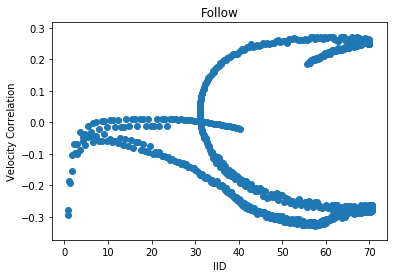

In [34]:
follow_simulation = follow(simulation[0,:,:], simulation[1,:,:])
plt.scatter(follow_simulation[1], follow_simulation[0])
plt.xlabel('IID')
plt.ylabel('Velocity Correlation')
plt.title('Follow')
plt.show()

#### Average Locations, Relative Positions and IID for Simulated Fish

In [102]:
X_sim, Y_sim = [], []
IID_sim = []
relative_pos_sim_1, relative_pos_sim_2 = [[], []], [[], []]

trajectory_type = int(input('Enter 0 for a normal LSTM and 1 for a ConvLSTM:'))

for i in range(50):
    while True:
        if include_data_rf ==0:
            data_2_fish = import_data(train_path, 1,1,1)
            p = 0 
        else:
            p = np.random.uniform(0, 1)
            if p < 0.5:
                data_2_fish = import_data(train_path, 1,1,1)
            else:
                data_2_fish = import_data_csv_rf(train_path_rf, 1, 1)
        if np.shape(data_2_fish)[1] == 2:
            break
            
    data_2_fish = data_2_fish[0]
    no_of_control_agents = 0
    no_of_simulated_agents = 2
    time_steps = 525
    limit = 75
    control_agents_data = data_2_fish[1:, 1:, :]
    X_inner = []
    Y_inner = []
    dx_inner = []
    dy_inner = []
    spd_inner = []
    ang_v_inner = []
    
    for j in range(2):
        if p <0.5:
            random_selection = np.random.randint(1, 201)
        else:
            random_selection = np.random.randint(1, 5000)
        X_inner.append(data_2_fish[j,random_selection,0])
        Y_inner.append(data_2_fish[j,random_selection,1])
        dx_inner.append(data_2_fish[j,random_selection,2])
        dy_inner.append(data_2_fish[j,random_selection,3])
        spd, a_vel = return_speeds(data_2_fish[j,random_selection,:], data_2_fish[j,random_selection - 1,:], 0.8, 0.8)
        spd_inner.append(spd)
        ang_v_inner.append(a_vel)
    simulation = simulate_trajectory_for_avg_position(load_path, no_of_simulated_agents, no_of_control_agents, control_agents_data, time_steps, limit, max_dist, wall_boundaries, no_of_bins_voa, no_of_bins_vow, total_angle_vow, total_angle_voa, max_speed, speed_bins, max_ang_velo, ang_vel_bins, trajectory_type, X_inner, Y_inner, dx_inner, dy_inner, spd_inner, ang_v_inner)
    
    for j in range(2):
        X_sim.extend(simulation[j,:,0])
        Y_sim.extend(simulation[j,:,1])
        relative_pos_sim_1[j].extend((simulation[1,:,j] - simulation[0,:,j]))    
        relative_pos_sim_2[j].extend((simulation[0,:,j] - simulation[1,:,j])) 
        
    IID_sim.extend(np.sqrt(np.square(simulation[0,:,0]-simulation[1,:,0]) + np.square(simulation[0,:,1]-simulation[1,:,1])))
    
    print('Iteration: {}'.format(i + 1))

Enter 0 for a normal LSTM and 1 for a ConvLSTM:0
Iteration: 1
Iteration: 2
Iteration: 3


KeyboardInterrupt: 

#### Average Locations, Relative Positions and IID for Actual Fish

In [89]:
X, Y = [], []
IID = []
relative_pos_1, relative_pos_2 = [[], []], [[], []]

trajectory_type = int(input('Enter 0 for a normal LSTM and 1 for a ConvLSTM:'))

if include_data_rf ==0:
    fish_data = import_data(train_path, 0,1,1)
    p = 0 
else:
    fish_data = import_data(train_path, 0,1,1)
    robot_fish_data = import_data_csv_rf(train_path_rf, 0, 1)

for i in range(len(fish_data)):
    
    if np.shape(fish_data[i])[0] == 2:

        for j in range(2):
            X.extend(fish_data[i][j, : ,0])
            Y.extend(fish_data[i][j, : ,1])
            relative_pos_1[j].extend((fish_data[i][1,:,j] - fish_data[i][0,:,j]))    
            relative_pos_2[j].extend((fish_data[i][0,:,j] - fish_data[i][1,:,j]))

        X_2 = np.square(fish_data[i][1,:,0] - fish_data[i][0,:,0])
        Y_2 = np.square(fish_data[i][1,:,1] - fish_data[i][0,:,1])
        IID.extend(np.sqrt(X_2 + Y_2))
    print('Iteration: {}'.format(i + 1))
    
i_old = i 

if include_data_rf == 1:
    for i in range(len(robot_fish_data)):        

        for j in range(2):
            X.extend(fish_data[i][j, : ,0])
            Y.extend(fish_data[i][j, : ,1])
            relative_pos_1[j].extend((fish_data[i][1,:,j] - fish_data[i][0,:,j]))    
            relative_pos_2[j].extend((fish_data[i][0,:,j] - fish_data[i][1,:,j]))

        X_2 = np.square(fish_data[i][1,:,0] - fish_data[i][0,:,0])
        Y_2 = np.square(fish_data[i][1,:,1] - fish_data[i][0,:,1])
        IID.extend(np.sqrt(X_2 + Y_2))
    

    print('Iteration: {}'.format(i_old + i + 1))

Enter 0 for a normal LSTM and 1 for a ConvLSTM:0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteratio

In [42]:
np.shape(fish_data)

(467, 750, 4)

### Positions Heat Map

#### Simulated Fish

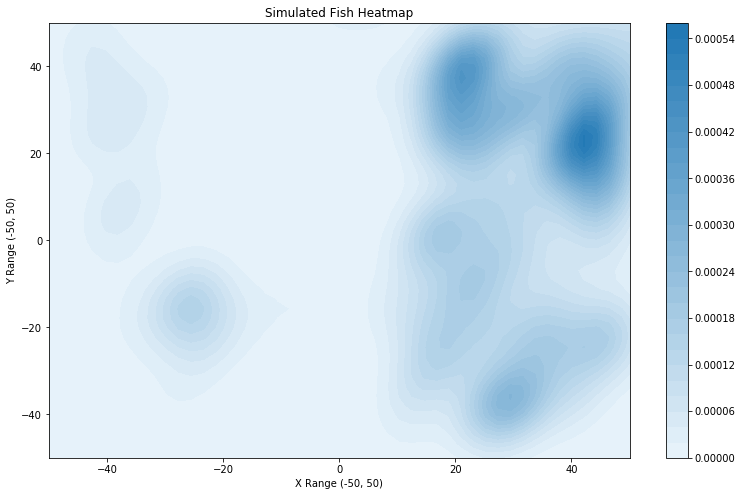

In [157]:
plot_average_positions(X_sim,Y_sim, 'Simulated Fish Heatmap', 30, 8, 50, 50)

#### Actual Fish

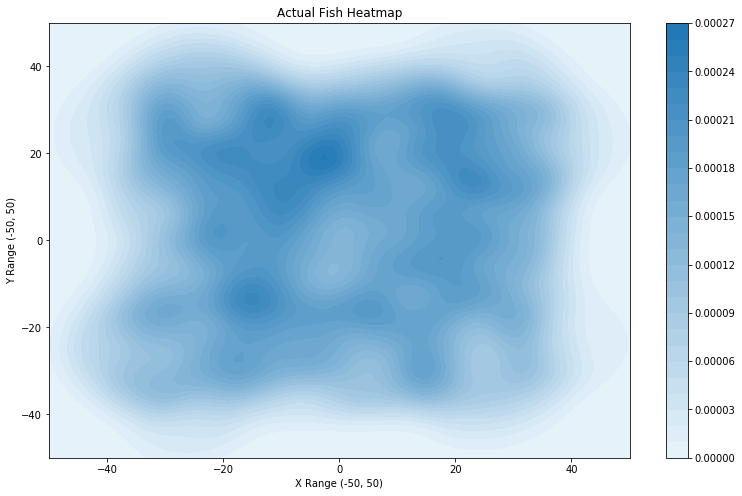

In [88]:
plot_average_positions(X,Y, 'Actual Fish Heatmap', 30, 8, 50, 50)

### Relative Positions

#### Simulated Fish: Fish 2 relative to Fish 1

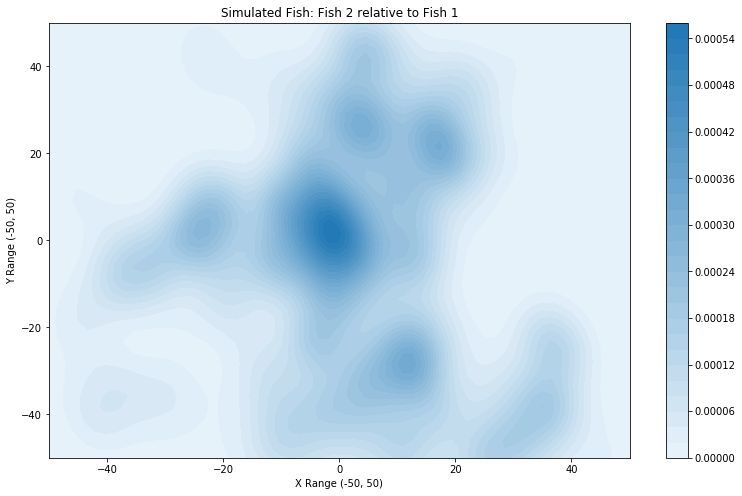

In [159]:
plot_average_positions(relative_pos_sim_1[0],relative_pos_sim_1[1], 'Simulated Fish: Fish 2 relative to Fish 1', 30, 8, 50, 50)

#### Simulated Fish: Fish 1 relative to Fish 2

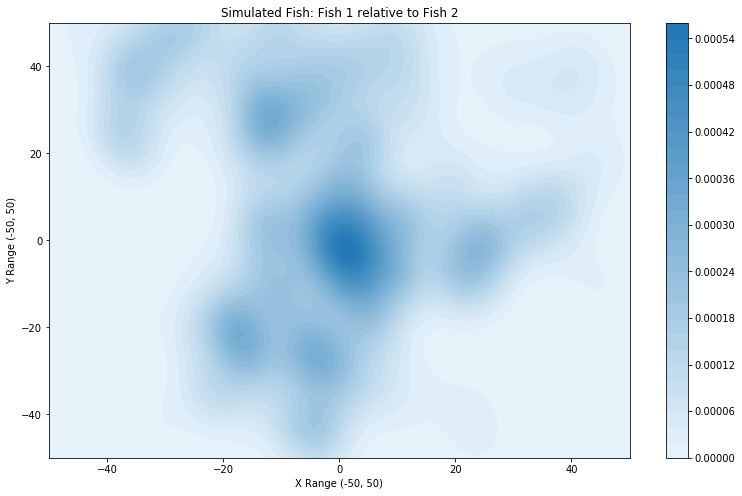

In [160]:
plot_average_positions(relative_pos_sim_2[0],relative_pos_sim_2[1], 'Simulated Fish: Fish 1 relative to Fish 2', 30, 8, 50, 50)

#### Actual Fish: Fish 2 relative to Fish 1

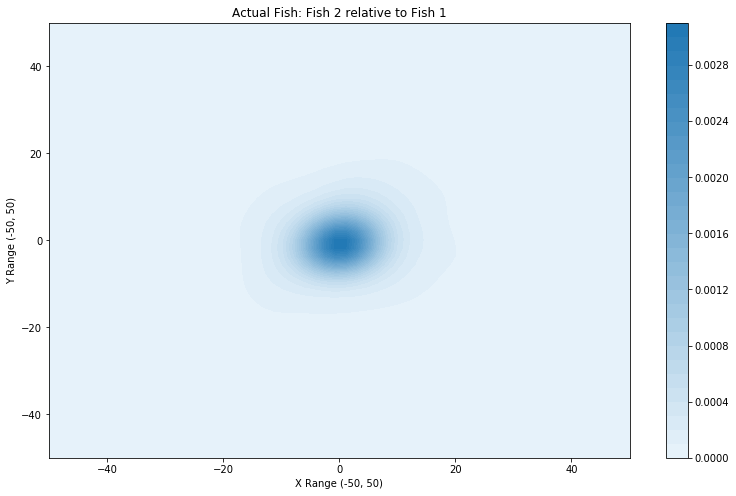

In [90]:
plot_average_positions(relative_pos_1[0],relative_pos_1[1], 'Actual Fish: Fish 2 relative to Fish 1', 30, 8, 50, 50)

#### Actual Fish: Fish 1 relative to Fish 2

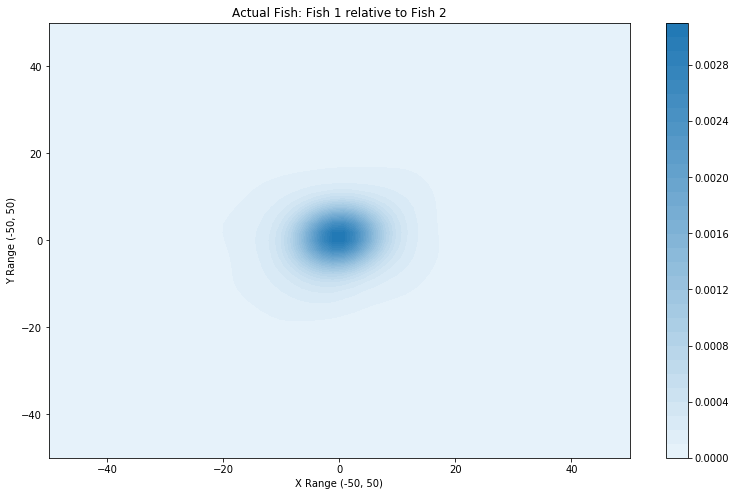

In [91]:
plot_average_positions(relative_pos_2[0],relative_pos_2[1], 'Actual Fish: Fish 1 relative to Fish 2', 30, 8, 50, 50)

#### IID Distribution of Simulated Fish

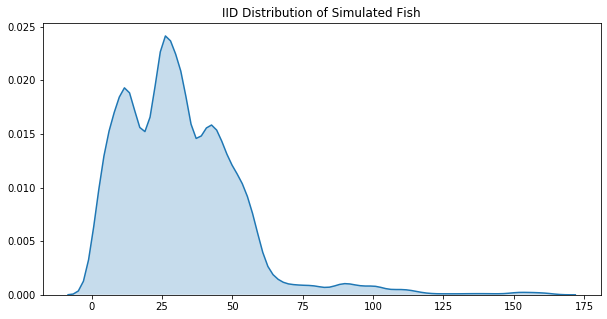

In [163]:
plot_distribution(IID_sim, 'IID Distribution of Simulated Fish', 5)

#### IID Distribution of Actual Fish

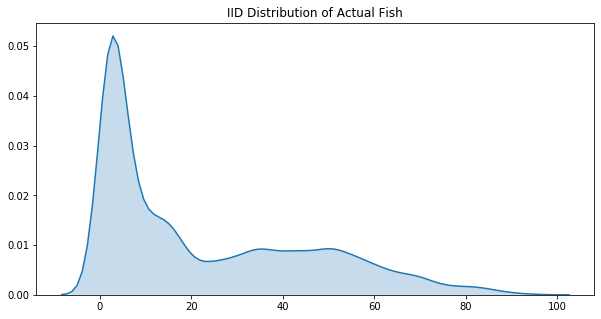

In [103]:
plot_distribution(IID, 'IID Distribution of Actual Fish', 5)

### Actual Fish Animation

In [ ]:
animate(AgentAnimation, data_2_fish, 'Fish Data Couzin', time_steps, 75)

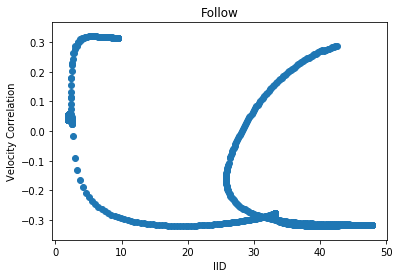

In [40]:
follow_live_fish = follow(data_2_fish[0,:,:], data_2_fish[1,:,:])
plt.scatter(follow_live_fish[1], follow_live_fish[0])
plt.xlabel('IID')
plt.ylabel('Velocity Correlation')
plt.title('Follow')
plt.show()
plt.show()